# Bibliotecas

Só o básico

> Usando nltk para filtrar palavras irrelevantes, o resto é meio sugestivo

In [23]:
# %pip install -r requirements.txt

In [24]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from random import shuffle

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pesadaum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Lendo o texto

In [25]:
df = pd.read_csv('./data/wc-text.csv')

df.replace('\n', ',', regex=True, inplace=True)

df.head()

,Unnamed: 0,Quais palavras ou frases você gostaria que aparecessem na nuvem?
0,7,Python
1,12,"Function, C, return, goto"
2,19,"Programar, stress, café, saporra não funciona."
3,21,"Alan Turing, programação, trabalho"
4,31,"Ensino, programação, aprendizado, tecnologia"


In [26]:
df_2 = pd.read_csv('./data/words.csv')

df_2.replace('\n', ',', regex=True, inplace=True)
df_2.dropna(inplace=True)

df_2.head()

,Unnamed: 0,"Independente de querer comprar ou não, coloque aqui palavras ou frases que descrevam seu curso e/ou a UNIFEI para compor a nuvem da camisa"
1,2,Lógica
3,4,Determinação
6,7,bugou
8,9,Silício
9,10,C++


In [27]:
l1 = df.iloc[:,-1].to_list()
l2 = df_2.iloc[:,-1].to_list()

l = l1 + l2


## Removendo palavras sem utilidade

In [28]:
stops_dir = str('/home/pesadaum/development/projects/word_cloud/data/corpora/stopwords/')
stops = nltk.corpus.stopwords.words(stops_dir + 'portuguese')
stops += nltk.corpus.stopwords.words(stops_dir + 'english')

In [29]:
text = ' '.join(l)
text = text.replace(' ', ',')
text = text.replace(r'"', '')

for i in range(5):
    #gambiarra pra tirar as vírgulas repetidas. Deveria usar Regex mas tem tempo irmão
    text = text.replace(',,', ',')

text = text.title()

l = text.split(',')

# Teve uma pessoa que escreveu 'Eam' l.count('Eam') vezes, então ...
for i in range(l.count('Eam')):
    text += 'ECO, ECA, EEL, EMB, EMT, EME, EPR, ESS, '

l = text.split(',')

shuffle(l)

text = ' '.join(l)

text[:100]


'Ambiental Rodrigo  EMT Vagas Alan Não Turing Desenvolvimento Alan Controle Ambiental Puthon Drogas A'

# Lendo a imagem

Não é nenhuma mágica (até agora), é só ler a imagem e transformar num array numpy com formato ou *shape* (x, y, 3). Qualquer função de ler imagem serve.

A linha seguinte (`img = img[::3,::3]`) reduz a qualidade da imagem, é útil pra fazer o código rodar mais rápido.

In [30]:
img = np.array(Image.open('./img_in/unifei_logo.png'))
img = img[::3,::3]

# Processando as bordas

Usando a média do gradiente de Gauss dá pra filtrar a imagem legal e usar o realce das bordas como os eixos para as trocas de cor. A função pode parecer meio maluca à primeira vista. E é mesmo. Vamos ao passo a passo:

1. Normaliza as componentes de cor da imagem para cada canal de cor RGB (aquela parte que divide por 255 e fala `for i in range(3)` que é pra cada canal de cor) e joga an variável `gradient`
2. Tira a média do resultado e joga na variável `edges` 
3. Copia os valores de cor da imagem pra variável `img_mask`
4. Se para cada valor de `edges` for maior que o gatilho escolhido (`mask_threshold`), a imagem terá cor. Caso contrário, não terá.
5. Ufa


In [31]:
gradient =  [gaussian_gradient_magnitude(img[:, :, i] / 255., sigma=1) for i in range(3)]
edges = np.mean(gradient, axis=0)

mask_thresh = 0.008
img_mask = img.copy()
img_mask[img_mask.sum(axis=2) == 0] = 255
img_mask[edges > mask_thresh] = 255

# Gerando o WordCloud

Processar a imagem tá praticamente feito, agora basta gerar a nuvem. Algumas considerações:

- rel_scaling: não fez diferença evidente trocar para 0 ou para 1, então deixei em `'auto'`
- max_words: com umas 2000 palavras já dá um resultado aceitável, dá pra usar o comprimento (em caracteres) do próprio texto pra deixar esse valor no automático
  * 5000 palavras demora uns 3m então melhor ir com cuidado 
- font: só especificar o caminho da fonte pro arquivo `.ttf`
- scale: aumenta a escala da imagem. Por padrão e 1 e produz uma imagem de $1000 \times 1000$. Aumentar a escala também melhora a qualidade (e o tamanho do png)

In [32]:
rel_scaling = 'auto'
max_words = 5000
font = './Exo_2/Exo2-VariableFont_wght.ttf'
scale = 2

wc = WordCloud(
    mask=img_mask, 
    max_words=max_words,
    font_path=font,
    stopwords=stops,
    scale=scale,
    mode="RGBA",
    background_color=None,
    max_font_size=100,
    random_state=2,
    relative_scaling=rel_scaling,
    min_font_size=1, 
    repeat=True)

wc.generate(text)

# Colorindo o WordCloud

Por padrão, a saída do wordcloud é binária (com cor, sem cor, <strike>cor sim cor não</strike>) então usamos uma função mão na roda que extrai as cores sem muito mistério

In [33]:
image_colors = ImageColorGenerator(img)
wc.recolor(color_func=image_colors)

# Salvando o arquivo

Falta só salvar o arquivo agora. O PNG tem uma qualidade suficientemente boa mas como esse pessoal que faz o kit é maluco podemos salvar em SVG também. 

- Para salvar em PNG é só usar a função do próprio módulo `to_file('nome_do_arquivo.png')`. Essa função não suporta SVG nativamente, então a gente usa gambiarra:
- Para salvar em SVG a gente usa a função de converter pra PNG (que retorna uma string) e grava essa string num arquivo. Voillá! Temos um Wordcloud!

In [34]:
from datetime import datetime

now = str(datetime.now())

wc_svg = wc.to_svg(embed_font=True)
with open('./img_out/wc.svg' + now + '.svg', 'w') as f:
    f.write(wc_svg)

wc.to_file(f'./img_out/wc_{now}_.png')

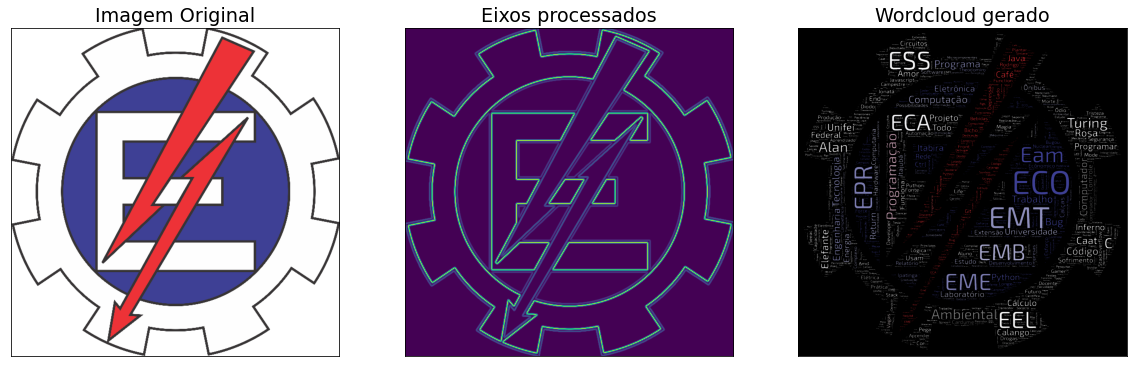

In [45]:
plt.rc('font', size=16)

f, ax = plt.subplots(ncols=3, figsize=(20, 10))

ax[0].imshow(img)
ax[1].imshow(edges)
ax[2].imshow(wc, interpolation='bilinear')

for i in ax:
    i.set(
        xticks=[], yticks=[]
    )

ax[0].set(
    title='Imagem Original'
)

ax[1].set(
    title='Eixos processados'
)

ax[2].set(
    title='Wordcloud gerado',
    facecolor='black'
)

plt.show()

# Vendo as palavras mais frequentes

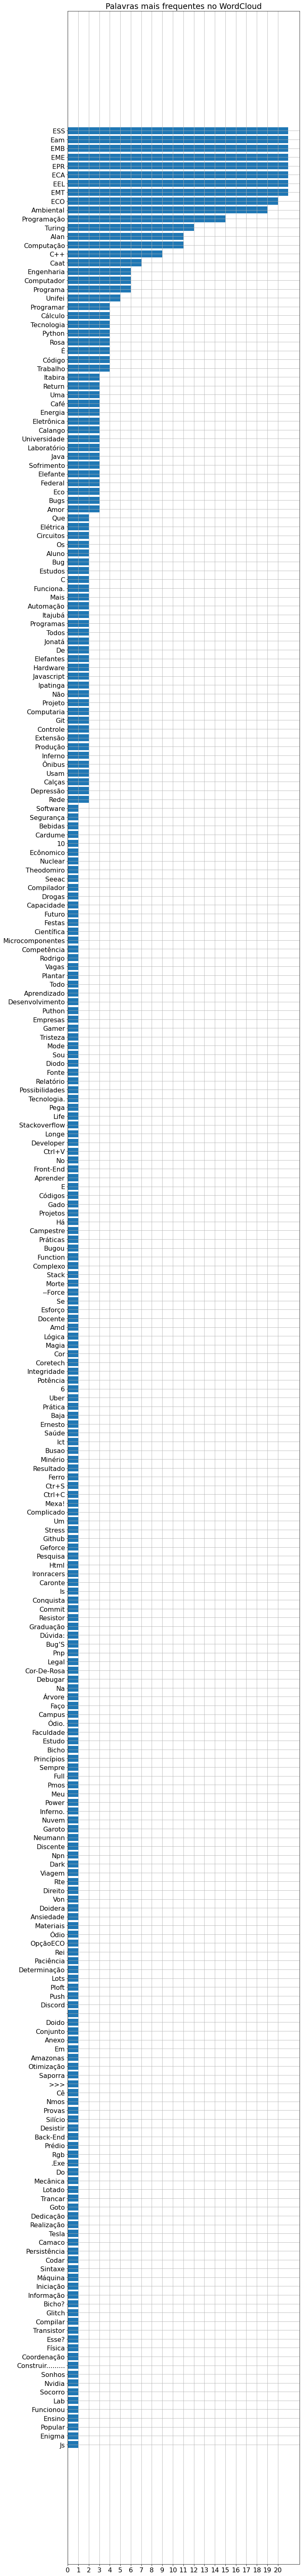

In [44]:
ctr = Counter(l)
d = pd.DataFrame.from_records([ctr.keys(), ctr.values()]).T
d = d.sort_values(by=1)

f, ax = plt.subplots(figsize=(9, len(d)//3))

f.tight_layout()
ax.set_title('Palavras mais frequentes no WordCloud')

ax.barh(d[0], d[1])

ax.set_xticks(range(d[1].max()))
ax.grid()

plt.show()


![](./img_out/wc_color_dummy.png)